# Modeling void fraction in fluid channel using cross-sectional disks

This notebook is designed for analysis of neutron data
which describes void fraction of refrigerant
flowing through a microfluidic channel.

Created on Thu Feb 13 10:33:13 2020  
author: ericmuckley@gmail.com

Full repository can be viewed at  
https://github.com/ericmuckley/fluid_channel_modeling

In [1]:
import os
#import cv2
import numpy as np
#from glob import glob
#from time import time

from matplotlib import patches
import matplotlib.pyplot as plt

from scipy.interpolate import splev
from scipy.optimize import curve_fit
from scipy.interpolate import splrep

from lmfit import minimize, Parameters, fit_report

from shapely.geometry.polygon import Polygon
from shapely.geometry import LineString, Point

In [2]:
# change matplotlib settings to make plots look nicer
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 3
plt.rcParams['xtick.minor.width'] = 3
plt.rcParams['xtick.major.width'] = 3
plt.rcParams['ytick.minor.width'] = 3
plt.rcParams['ytick.major.width'] = 3

def plot_setup(labels=['X', 'Y'], fsize=18, title='', size=None):
    """Creates a custom plot configuration to make graphs look nice.
    This should be called between plt.plot() and plt.show() commands."""
    plt.xlabel(str(labels[0]), fontsize=fsize)
    plt.ylabel(str(labels[1]), fontsize=fsize)
    plt.title(title, fontsize=fsize)

def plot_channel_image(image, title=None, vmin=None, vmax=None):
    """Plot image of the channel, colored by void fraction."""
    plt.imshow(image, origin='lower', cmap='jet', vmin=vmin, vmax=vmax, )
    fig = plt.gcf()
    fig.set_size_inches(11,11)
    plt.axis('off')
    if title is not None:
        plt.title(title, fontsize=16)
    plt.show()

def multi_ellipse_integral(x, *params):
    """
    This is the same function as 'ellipse_integral'
    but allows for fitting of multiple ellipses at once.
    The number of params varies based on the number of cross
    sections to fit.
    """
    y = np.zeros_like(x, dtype='float')
    for i in range(0, len(params), 3):
        c = params[i]
        w = params[i+1]
        h = params[i+2]
        new_profile = h * np.sqrt(1 - np.square(x-c) / np.square(w/2))
        y = y + np.nan_to_num(new_profile)
    return y

def ellipse_integral_lmfit(params, x, y):
    """
    Fitting function for the integral over an ellipse using the lmfit library
    """
    x0 = params['x0']
    w = params['w']
    h = params['h']
    integral = np.nan_to_num(h * np.sqrt(1 - np.square(x-x0)/np.square(w/2)))
    return y - integral


def ellipse_integral(x, c, w, h):
    """
    Get intetral of ellipse across 'x' range, with center at 'c',
    width 'w', and height 'h'.
    """
    y = h * np.sqrt(1 - np.square(x-c)/np.square(w))
    return np.nan_to_num(y)


def resample(arr, new_len=100, new_xlims=None, vec_scale='lin', k=2, s=0):
    """
    Resamples (stetches/compresses) a 2D array by using a spline fit.
    Array should be shape [[x1, y1, ...ym], ...[xn, yn, ...yn]] where the
    # first column in array is x-values and following next columns are
    y values. If no x values exist, insert column np.arange(len(arr))
    as x values.Accepts linear or log x-values, and new x_limits.
    k and s are degree and smoothing factor of the interpolation spline.
    """
    # check whether array should be resampled using linear or log scale
    new_scale = np.geomspace if vec_scale == 'log' else np.linspace

    # get new x-limits for the resampled array
    if new_xlims is None:
        new_x1, new_x2 = arr[0, 0], arr[-1, 0]
    else:
        new_x1, new_x2 = new_xlims[0], new_xlims[1]
    # create new x values
    arrx = new_scale(new_x1, new_x2, new_len)
    # create new empty array to hold resampled values
    stretched_array = np.zeros((new_len, len(arr[0])))
    stretched_array[:, 0] = arrx 
    # for each y-column, calculate parameters of degree-3 spline fit
    for col in range(1, len(arr[0])):
        spline_params = splrep(arr[:, 0], arr[:, col], k=int(k), s=s)
        # calculate spline at new x values
        arry = splev(arrx, spline_params)
        # populate stretched data into resampled array
        stretched_array[:, col] = arry
    return stretched_array

def find_intersections(op_list1, op_list2):
    """
    Find all intersections between two curves. Curves are defined by lists
    of ordered pairs (x, y). Returns 'None' if no intersections are found.
    """
    intersections = None
    # loop over each pair of line segments
    for i1 in range(len(op_list1)-1):
        for i2 in range(len(op_list2)-1):
            # create segment from the first set of points
            seg1 = LineString([(op_list1[i1][0], op_list1[i1][1]),
                            (op_list1[i1+1][0], op_list1[i1+1][1])])
            # create segment from the second set of points
            seg2 = LineString([(op_list2[i2][0], op_list2[i2][1]),
                            (op_list2[i2+1][0], op_list2[i2+1][1])])
            # check if segment from set-1 intersects segment from set-2
            if seg1.intersects(seg2):
                avg_x = np.mean([op_list1[i1][0], op_list1[i1+1][0],
                                op_list2[i2][0], op_list2[i2+1][0]])
                avg_y = np.mean([op_list1[i1][1], op_list1[i1+1][1],
                                op_list2[i2][1], op_list2[i2+1][1]])
                if intersections is None:
                    intersections = [[avg_x, avg_y]]
                else:
                    intersections.append([avg_x, avg_y])
    return intersections

def get_ellipse_vertices(ellipse):
    """
    Transform matplotlib.patches.ellipse object into a
    2D array of vertices for plotting the ellipse.
    """
    raw_vertices = ellipse.get_path().vertices
    center = ellipse.center
    vertices = np.copy(raw_vertices)
    vertices[:, 0] = vertices[:, 0] * ellipse.width/2 + center[0]
    vertices[:, 1] = vertices[:, 1] * ellipse.height/2 + center[1]
    return vertices

## Get image list

Get list of all images which we will model.

In [3]:
# navigate to data folder
data_path = os.path.join(os.getcwd(), 'data', 'compiled_data.npy')

data = np.load(data_path, allow_pickle=True)[()]
print(list(data))

['w_um', 'h_um', 'd_um', 'um_per_pixel', 'buffer_um', 'min_rad_um', 'max_rad_um', 'channels']


## Do something



In [4]:
'''
# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']
    print(img.shape)
'''

"\n# loop over each image\nfor L in data['channels']:\n    img = data['channels'][L]['img_voidfrac']\n    print(img.shape)\n"

In [5]:
'''
plot_channel_image(img, title='Void fraction: {}'.format(L))

x = np.arange(100)
y = multi_ellipse_integral(x, 20, 9, 4, 60, 4, 5)
plt.plot(x,y)
plt.show()
'''

"\nplot_channel_image(img, title='Void fraction: {}'.format(L))\n\nx = np.arange(100)\ny = multi_ellipse_integral(x, 20, 9, 4, 60, 4, 5)\nplt.plot(x,y)\nplt.show()\n"

from lmfit.models import LorentzianModel, ConstantModel
import numpy as np
import matplotlib.pyplot as plt

x, y = np.loadtxt('Peaks.txt', unpack=True)

peaks_in_interval = np.array([43, 159, 191, 296, 435, 544])
number_of_peaks = len(peaks_in_interval)
amplitude = y[peaks_in_interval] / 5
width = np.zeros(number_of_peaks) + 0.1
center = x[peaks_in_interval]

def multi_ellipse_lmfit(n):
    """
    Fit integral over 'n' number of ellipses using the
    lmfit package
    """
    num = "_f{0}".format(n)
    model = LorentzianModel(prefix = pref)
    model.set_param_hint('amplitude'+num, value=amplitude[num], min=0, max=5*amplitude[num])
    model.set_param_hint('center'+num, value=center[num], min=center[num]-0.5, max=center[num]+0.5)
    model.set_param_hint('sigma'+num, value=width[num], min=0, max=2)
    return model

mod = None
for i in range(len(peaks_in_interval)):
    this_mod = make_model(i)
    if mod is None:
        mod = this_mod
    else:
        mod = mod + this_mod

offset = ConstantModel()
offset.set_param_hint('c', value=np.average(y[-75:]))
mod = mod + offset

out=mod.fit(y, x=x, method='nelder')
plt.interactive(True)
print(out.fit_report())
plt.plot(x, y)
plt.plot(x, out.best_fit, label='best fit')
plt.plot(x, out.init_fit, 'r--', label='fit with initial values')
plt.show()


fitted parameters: {'x0': 5.011460288770355, 'w': 8.999999999758227, 'h': 121.56862745098009}


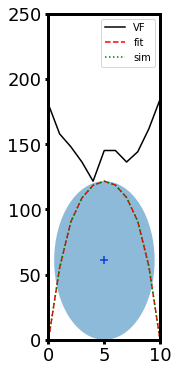

fitted parameters: {'x0': 8.9999999998147, 'w': 4.118231208811242, 'h': 121.56859434568416}


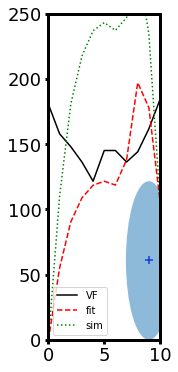

fitted parameters: {'x0': 6.519333990779973, 'w': 1.0386663487852905, 'h': 1.3792007954937682}


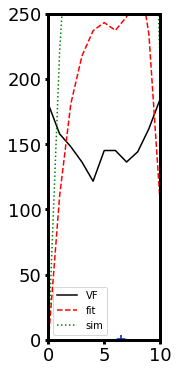

fitted parameters: {'x0': 4.500855427573685, 'w': 1.001702643918295, 'h': 1.165376506875865}


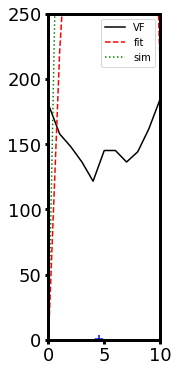

fitted parameters: {'x0': 3.996200729407854, 'w': 1.7790091247399649, 'h': 1.000000001032454}


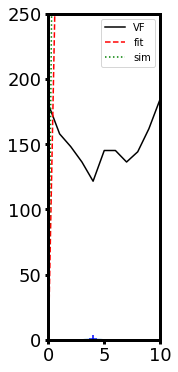

In [20]:
# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']

# create cross sectional profile, and the simulated cross section
cs = np.column_stack((np.arange(img.shape[0]), img[:, 0]))
sim = np.zeros_like(cs[:, 1])


for _ in range(5):
    
    # specify fitting parameters for lmfit routine
    input_params = Parameters()
    input_params.add('x0', value=np.max(cs[:, 0])/2, min=1, max=np.max(cs[:, 0])-1)
    input_params.add('w', value=np.max(cs[:, 0])/2, min=1, max=np.max(cs[:, 0])-1)
    input_params.add('h', value=np.max(cs[:, 1])/2, min=1, max=np.min(cs[:, 1]))

    # run minimization
    out = minimize(ellipse_integral_lmfit, input_params, args=(cs[:, 0], cs[:, 1]-sim))

    # get residuals and fitted parameters
    residual = out.residual
    fitted_params = {k: v.value for (k, v) in out.params.items()}
    print('fitted parameters: {}'.format(fitted_params))
    fit = cs[:, 1] - residual
    sim += fit

    # plot all fitted ellipse
    fig, ax = plt.subplots()
    ellipse_object = patches.Ellipse((fitted_params['x0'], fitted_params['h']/2),
                                     fitted_params['w'],
                                     fitted_params['h'],
                                     alpha=0.5)
    ax.add_patch(ellipse_object)
    # plot ellipse center marker
    ax.scatter(fitted_params['x0'], fitted_params['h']/2, marker='+', s=60, c='b')

    # plot measured cross section
    plt.plot(cs[:, 0], cs[:, 1], c='k', label='VF')
    # plot simulated cross section
    plt.plot(cs[:, 0], fit, c='r', linestyle='--', label='fit')
    
    plt.plot(cs[:, 0], sim, c='g', linestyle='dotted', label='sim')
    fig.set_size_inches(2, 6)
    plt.xlim([0, np.max(cs[:, 0])])
    plt.ylim([0, data['d_um']])
    plt.legend()
    plt.show()

    


In [7]:
out.residual

array([180.39215686, 102.75463387,  57.70518266,  27.52670838,
         3.11068731,  23.529806  ,  26.49896862,  27.21949505,
        53.2297743 , 105.47467957, 184.31372549])

In [8]:
'''
def get_guess(cs, n):
    """
    Get initial guess for fitting void fraction
    profile to multiple ellipsoidal discs. A guess is
    required for multi-peak fitting so that the number of
    fit parameters remained fixed.
    Inputs:
    cs: cross section to fit ([x, y] 2D array)
    n: number of ellipses to fit
    """
    guess = []
    low_bounds = []
    high_bounds = []
    center_increment = (np.max(cs[:, 0])-np.min(cs[:, 0]))/n
    
    for g in range(n):
        guess += [
            (np.max(cs[:, 0])-np.min(cs[:, 0]))/2,#center_increment*(g+1) - n, # center x-coordinate
            (np.max(cs[:, 0])-np.min(cs[:, 0]-1))/(2), # x-radius
            np.mean(cs[:, 1])/2] # y-radius
        low_bounds += [1]*3
        high_bounds += [np.max(cs[:, 0])-1, np.max(cs[:, 0]), np.max(cs[:, 1])]
        #high_bounds += [np.inf, np.inf, np.inf]
    print('guess')
    print(np.reshape(guess,((-1, 3))))
    print('low bounds')
    print(np.reshape(low_bounds, (-1, 3)))
    print('high_bounds')
    print(np.reshape(high_bounds, (-1, 3)))
    return guess, (low_bounds, high_bounds)



# loop over each image
for L in data['channels']:
    img = data['channels'][L]['img_voidfrac']

# create a cross sectional profile to fit

#cs = np.column_stack(([-1, 0, 1,2,3,4,5,6,7,8,9,10,11],
#                     [0] + list(img[:, 0]) + [0]))
    
cs = np.column_stack((np.arange(img.shape[0]), img[:, 0]))



#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:, 0])))

# perform fitting
guess, bounds = get_guess(cs, 1)
popt, _ = curve_fit(multi_ellipse_integral, cs[:, 0], cs[:, 1], p0=guess, bounds=bounds)
fit = multi_ellipse_integral(cs[:, 0], *popt)
print('fit results')
print(popt.reshape((-1, 3)))

# plot all fitted ellipses
fig, ax = plt.subplots()
for i in range(0, len(popt), 3):
    ellipse_object = patches.Ellipse((popt[i], popt[i+2]/2), popt[i+1], popt[i+2], alpha=0.5)
    ax.add_patch(ellipse_object)

# plot measured cross section
plt.plot(cs[:, 0], cs[:, 1], c='k')
# plot simulated cross section
plt.plot(cs[:, 0], fit, c='r', linestyle='--', label='fit')
fig.set_size_inches(2, 6)
plt.xlim([0, np.max(cs[:, 0])])
plt.ylim([0, data['d_um']])
plt.show()
'''

'\ndef get_guess(cs, n):\n    """\n    Get initial guess for fitting void fraction\n    profile to multiple ellipsoidal discs. A guess is\n    required for multi-peak fitting so that the number of\n    fit parameters remained fixed.\n    Inputs:\n    cs: cross section to fit ([x, y] 2D array)\n    n: number of ellipses to fit\n    """\n    guess = []\n    low_bounds = []\n    high_bounds = []\n    center_increment = (np.max(cs[:, 0])-np.min(cs[:, 0]))/n\n    \n    for g in range(n):\n        guess += [\n            (np.max(cs[:, 0])-np.min(cs[:, 0]))/2,#center_increment*(g+1) - n, # center x-coordinate\n            (np.max(cs[:, 0])-np.min(cs[:, 0]-1))/(2), # x-radius\n            np.mean(cs[:, 1])/2] # y-radius\n        low_bounds += [1]*3\n        high_bounds += [np.max(cs[:, 0])-1, np.max(cs[:, 0]), np.max(cs[:, 1])]\n        #high_bounds += [np.inf, np.inf, np.inf]\n    print(\'guess\')\n    print(np.reshape(guess,((-1, 3))))\n    print(\'low bounds\')\n    print(np.reshape(low_bou

In [9]:
#len(popt)

## Add elipses to channel cross section

In [10]:
def points_inside_polygons(array_of_points, verts):
    """
    Check if an array of points lies inside any polygons. 
    Uses Point and Polygon objects from Shapley library.
    Inputs:
    array_of_points: 2D array of coordinate ordered pairs
    verts: list of arrays of vertices of each polygon
    """
    inside = np.zeros(len(array_of_points))
    # loop over each point
    for p in range(len(array_of_points)):
        point = Point(*array_of_points[p])
        for v in verts:
            polygon = Polygon(v)
            if polygon.contains(point):
                inside[p] = 1
                break
    return inside


def get_all_polygon_vertices(arr):
    """
    Get a list of ordered pairs of every polygon vertex
    from an array of lists of vertices
    """
    all_verts = []
    for p in arr:
        for v in p:
            all_verts.append(list(v))
    return all_verts
'''    


    

# use this to resample the cross section for higher resolution
#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:,i])))
cs = np.column_stack((np.arange(img.shape[0]), img[:, 60]))

# create dictionary for elliptical bubble dimensions (center, width, height)
# the initial bubble is created as large as possible to fit inside measured cross section
bub = {
    'c': [[np.max(cs[:, 0])/2, int(data['d_um']/2)]],
    'w': [np.max(cs[:, 0])],
    'h': [np.min(cs[:, 1])],
    'verts': []}

# create initial ellipse
ellipse_object = patches.Ellipse(bub['c'][0], bub['w'][0], bub['h'][0], alpha=0.5)
ellipse_vertices = get_ellipse_vertices(ellipse_object)
bub['verts'].append(ellipse_vertices)
# create simulated cross section to hold ellipse cross sections and plot it
sim_cs = ellipse_integral(cs[:,0], bub['c'][0][0], bub['w'][0], bub['h'][0])


# plot initial ellipse
fig, ax = plt.subplots()
ax.add_patch(ellipse_object)
ax.scatter(*bub['c'][0], marker='+', s=80, c='b')
# add void fraction cross section to plot
ax.plot(cs[:,0], cs[:,1], lw=2, c='k', label='meas. VF')

# create new bubbles
for b in range(1, 6):
    
    # calculate residual between measured and simulated cross sections
    residual = np.abs(cs[:, 1]-sim_cs)
    
    # ------------------------- generate new bubble ------------------------
    # get potential centers of new bubbles
    x_pot = np.arange(1, len(cs)-1)
    y_pot = np.arange(1, data['d_um']-1, 5)
    grid_cords = np.array(np.meshgrid(x_pot, y_pot)).T.reshape(-1,2)
    
    # check if potential center lies inside of any other bubbles
    inside_bubbles = points_inside_polygons(grid_cords, bub['verts']).astype('bool')
    good_pot = grid_cords[~inside_bubbles]

    # loop over potential candidates for new bubbles
    new_residual_list = []
    for gpi in range(len(good_pot)):
        # get coordinates of prperties of potential candidate
        x, y = good_pot[gpi]
        w_max = 2*np.min([x, np.max(cs[:,0])-x])
        h_max = 2*np.min([y, data['d_um']-y])
        #area_max = w_max * h_max * np.pi
        
        # get ellipse of potential candidate
        ellipse_object = patches.Ellipse((x, y), w_max, h_max, alpha=0.3)
        ellipse_vertices = get_ellipse_vertices(ellipse_object)

        # make sure potential ellipse doesn't overlap other existing ellipses
        all_previous_verts = get_all_polygon_vertices(bub['verts'])
        if find_intersections(ellipse_vertices, all_previous_verts) is None:
            #ax.add_patch(ellipse_object)
            
            new_cs = sim_cs + ellipse_integral(cs[:,0], x, w_max, h_max)

            new_residual_list.append(np.abs(cs[:, 1]-new_cs))
        else:
            new_residual_list.append(residual)
      
    best_idx = np.argmin(np.sum(np.array(new_residual_list), axis=1))
    x, y = good_pot[best_idx]
    
    new_c, new_w, new_h = [x, y], 2*np.min([x, np.max(cs[:,0])-x]), 2*np.min([y, data['d_um']-y])
    bub['c'].append(new_c)
    bub['w'].append(new_w)
    bub['h'].append(new_h)
    

    # add ellipse cross section to total simulated cross section 
    sim_cs += ellipse_integral(cs[:,0], new_c[0], new_w, new_h)
    # plot new ellipse
    ellipse_object = patches.Ellipse(new_c, new_w, new_h, alpha=0.5)
    # save vertices
    ellipse_vertices = get_ellipse_vertices(ellipse_object)
    bub['verts'].append(ellipse_vertices)
    ax.add_patch(ellipse_object)
    ax.scatter(*bub['c'][b], marker='+', s=80, c='b')
    
   

        
        
        
        
    # plot potential new bubble centers
    #[ax.scatter(*pot, s=2, c='gray') for pot in good_pot]

    
    print('Total residual: {}'.format(np.round(np.sum(residual), 2)))
    
# plot simulated void fraction cross section
ax.plot(cs[:, 0], sim_cs, c='r', linestyle='--', label='sim. VF')
plt.xlim([cs[0, 0], cs[-1, 0]])
plt.ylim([0, data['d_um']])
fig.set_size_inches(2, 6)
#plt.legend()
plt.show()
print('Black line: \t measured void fraction profile')
print('Red line: \t simulated void fraction profile')
print('Blue ellipse: \t simulated elliptical bubble cross-section')
print('Blue cross: \t simulated bubble center')
'''

"    \n\n\n    \n\n# use this to resample the cross section for higher resolution\n#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:,i])))\ncs = np.column_stack((np.arange(img.shape[0]), img[:, 60]))\n\n# create dictionary for elliptical bubble dimensions (center, width, height)\n# the initial bubble is created as large as possible to fit inside measured cross section\nbub = {\n    'c': [[np.max(cs[:, 0])/2, int(data['d_um']/2)]],\n    'w': [np.max(cs[:, 0])],\n    'h': [np.min(cs[:, 1])],\n    'verts': []}\n\n# create initial ellipse\nellipse_object = patches.Ellipse(bub['c'][0], bub['w'][0], bub['h'][0], alpha=0.5)\nellipse_vertices = get_ellipse_vertices(ellipse_object)\nbub['verts'].append(ellipse_vertices)\n# create simulated cross section to hold ellipse cross sections and plot it\nsim_cs = ellipse_integral(cs[:,0], bub['c'][0][0], bub['w'][0], bub['h'][0])\n\n\n# plot initial ellipse\nfig, ax = plt.subplots()\nax.add_patch(ellipse_object)\nax.scatter(*bub['c'][0], m

In [11]:
'''
# use this to resample the cross section for higher resolution
#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:,i])))
cs = np.column_stack((np.arange(img.shape[0]), img[:, 60]))

# create simulated cross section to hold ellipse cross sections and plot it
sim_cs = np.zeros_like(cs[:, 1])#ellipse_integral(cs[:,0], bub['c'][0][0], bub['w'][0], bub['h'][0])

# create dictionary for bubble dimensions (center, width, height, and ellipse vertices)
bub = {'c': [], 'w': [], 'h': [], 'verts': []}

# plot void fraction cross section
fig, ax = plt.subplots()
ax.plot(cs[:,0], cs[:,1], lw=2, c='k', label='meas. VF')

# create new bubbles
for b in range(5):
    print('=============== bubble {} ================'.format(b))
    # calculate residual between measured and simulated cross sections
    residual = np.abs(cs[:, 1]-sim_cs)
    
    # ------------------------- generate new bubble ------------------------
    # get potential centers of new bubbles
    x_pot = np.arange(1, len(cs)-1)
    y_pot = np.arange(1, data['d_um']-1, 5)
    grid_cords = np.array(np.meshgrid(x_pot, y_pot)).T.reshape(-1,2)
    
    # check if potential center lies inside of any other bubbles
    inside_bubbles = points_inside_polygons(grid_cords, bub['verts']).astype('bool')
    good_pot = grid_cords[~inside_bubbles]
    print('found {} potential new bubble centers'.format(len(good_pot)))
    
    # loop over potential candidates for new bubbles
    new_residual_list = []
    pot_cents = []
    for gpi in range(len(good_pot)):
        # get coordinates of properties of potential candidate
        
        x, y = good_pot[gpi]
        w_max = 2*np.min([x, np.max(cs[:,0])-x])
        h_max = 2*np.min([y, data['d_um']-y])
        #area_max = w_max * h_max * np.pi

        for ww in range(1, int(np.floor(w_max))):
            for hh in range(1, int(np.floor(h_max)), 5):
                pot_cents.append(good_pot[gpi])
                # get ellipse of potential candidate
                ellipse_object = patches.Ellipse((x, y), ww, hh, alpha=0.3)
                ellipse_vertices = get_ellipse_vertices(ellipse_object)

                # make sure potential ellipse doesn't overlap other existing ellipses
                all_previous_verts = get_all_polygon_vertices(bub['verts'])
                if find_intersections(ellipse_vertices, all_previous_verts) is None:
                    #ax.add_patch(ellipse_object)

                    new_cs = sim_cs + ellipse_integral(cs[:,0], x, w_max, h_max)

                    new_residual_list.append(np.abs(cs[:, 1]-new_cs))
                else:
                    new_residual_list.append(residual)

    print('{} possible bubble shapes'.format(len([a for a in new_residual_list if a is not None])))
    
    best_idx = np.argmin(np.sum(np.array(new_residual_list), axis=1))
    x, y = pot_cents[best_idx]
    
    new_c, new_w, new_h = [x, y], 2*np.min([x, np.max(cs[:,0])-x]), 2*np.min([y, data['d_um']-y])
    bub['c'].append(new_c)
    bub['w'].append(new_w)
    bub['h'].append(new_h)
    

    # add ellipse cross section to total simulated cross section 
    sim_cs += ellipse_integral(cs[:,0], new_c[0], new_w, new_h)
    # plot new ellipse
    ellipse_object = patches.Ellipse(new_c, new_w, new_h, alpha=0.5)
    # save vertices
    ellipse_vertices = get_ellipse_vertices(ellipse_object)
    bub['verts'].append(ellipse_vertices)
    ax.add_patch(ellipse_object)
    ax.scatter(*new_c, marker='+', s=80, c='b')
    
    
    # plot potential new bubble centers
    #[ax.scatter(*pot, s=2, c='gray') for pot in good_pot]

    
    print('Total residual: {}'.format(np.round(np.sum(residual), 2)))
    
# plot simulated void fraction cross section
ax.plot(cs[:, 0], sim_cs, c='r', linestyle='--', label='sim. VF')
plt.xlim([cs[0, 0], cs[-1, 0]])
plt.ylim([0, data['d_um']])
fig.set_size_inches(2, 6)
#plt.legend()
plt.show()
print('Black line: \t measured void fraction profile')
print('Red line: \t simulated void fraction profile')
print('Blue ellipse: \t simulated elliptical bubble cross-section')
print('Blue cross: \t simulated bubble center')
'''

"\n# use this to resample the cross section for higher resolution\n#cs = resample(np.column_stack((np.arange(img.shape[0]), img[:,i])))\ncs = np.column_stack((np.arange(img.shape[0]), img[:, 60]))\n\n# create simulated cross section to hold ellipse cross sections and plot it\nsim_cs = np.zeros_like(cs[:, 1])#ellipse_integral(cs[:,0], bub['c'][0][0], bub['w'][0], bub['h'][0])\n\n# create dictionary for bubble dimensions (center, width, height, and ellipse vertices)\nbub = {'c': [], 'w': [], 'h': [], 'verts': []}\n\n# plot void fraction cross section\nfig, ax = plt.subplots()\nax.plot(cs[:,0], cs[:,1], lw=2, c='k', label='meas. VF')\n\n# create new bubbles\nfor b in range(5):\n    print('=============== bubble {} ================'.format(b))\n    # calculate residual between measured and simulated cross sections\n    residual = np.abs(cs[:, 1]-sim_cs)\n    \n    # ------------------------- generate new bubble ------------------------\n    # get potential centers of new bubbles\n    x_pot